In [11]:
import numpy as np
import torch
import scipy
import sympy as sp
import time

import sys
sys.path.insert(1, 'C:/Users/philh/Notebooks/jmp_solver/')
from sobolev import Sobolev
from solver import Solver
from utils import matmul
from diffeomorphisms import hyper_rect
import surrogates

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)

In [13]:
# Tests
# a=-1.0, b=1.0, q=3, sob_2d(deg=30), sob_1d(deg=100), model(n=30, p=np.inf), s=[0,-1], optimizer:LBFGS

### 2D Poisson Equation
Let $\Omega = (-1 , 1)^2, A, C, \omega, \beta \in \mathbb{R}$:
$${\large\begin{cases}
        \Delta u + f = 0, (x,y) \in \Omega\\
        u = g, (x,y) \in \partial \Omega
    \end{cases}}$$
with:
$$
    {\large f(x,y) = 2\lambda^2 cos(\lambda x) sin(\lambda y)}\\
    {\large g(x,y) = cos(\lambda x) sin(\lambda y)}\\
    {\large \lambda = 2 \pi q}
$$

In [14]:
rect = np.array([[-3.0, 3.0], [-1.0, 1.0]])

q = 1
lam = 2*np.pi*q

def f(x,y):
    return 2*lam**2*np.cos(lam*x)*np.sin(lam*y)

In [15]:
# Sobolev Cubature
diffeo_2d = hyper_rect(*rect)
diffeo_1d_0 = hyper_rect(rect[0])
diffeo_1d_1 = hyper_rect(rect[1])

sob_2d = Sobolev(deg=30, dim=2, diffeo=diffeo_2d)
sob_1d_0 = Sobolev(deg=100, diffeo=diffeo_1d_0)
sob_1d_1 = Sobolev(deg=100, diffeo=diffeo_1d_1)

dx2, dy2 = torch.tensor(sob_2d.diff.diffs(np.array([[2,0],[0,2]])))

In [16]:
# Surrogate Model
model = surrogates.Polynomial(
    n=30,
    p=np.inf,
    dim=2,
    scale=[np.max(np.abs(rect[0])), np.max(np.abs(rect[1]))])
model.set_weights_val(0.0)
model_deg = model.get_deg()

### Ground Truth

In [17]:
def gt(x,y):
    return np.cos(lam*x)*np.sin(lam*y)

### Gradient Flow

In [18]:
# |--------------------------------------------|
# |  Operator  |          Formulation          |  
# |------------|-------------------------------|
# | id         |  L2 grad of L2                | 
# | m_inv      |  L2 grad of Sob               |
# | weak m_inv |  L2 grad of weak Sob          |
# | m          |  L2 grad of negative Sob      |
# | weak m     |  L2 grad of weak negative Sob |
# |--------------------------------------------|
#
# For that use:
# -> sob.set_s(s)
# -> sob.metric(rev=False/True, weak=False/True)

In [19]:
# Sobolev Order
sob_2d.set_s(-1)

In [20]:
# Data
_, xs_bndr_0 = sob_1d_0.get_xs()
_, xs_bndr_1 = sob_1d_1.get_xs()
xs_plt, xs = sob_2d.get_xs()
leja_grid_2d = sob_2d.get_leja_grid()

dmn = model.data_axes(xs).T
bndr_0 = model.data_axes([xs_bndr_0[0], rect[1][0:1]]).T
bndr_0 = torch.cat((bndr_0, model.data_axes([xs_bndr_0[0], rect[1][1:2]]).T))
bndr_1 =  model.data_axes([[rect[0][0:1]], xs_bndr_1[0]]).T
bndr_1 = torch.cat((bndr_1, model.data_axes([rect[0][1:2], xs_bndr_1[0]]).T))

_x = leja_grid_2d[:,0]
_y = leja_grid_2d[:,1]

u_bndr_0 = torch.tensor(gt(xs_bndr_0[0], rect[1].reshape(-1,1)).reshape(-1))
u_bndr_1 = torch.tensor(gt(rect[0].reshape(-1,1), xs_bndr_1[0]).reshape(-1))

fXY = f(_x,_y)

# Sobolev Metrics
metric_2d = sob_2d.metric(weak=True)
metric_1d_0 = sob_1d_0.l2_metric()
metric_1d_1 = sob_1d_1.l2_metric()

# Formulation
K = dx2+dy2
eq = lambda u: matmul(K, u)+fXY
crit_dmn = lambda u: sob_2d.loss(eq(u), weak=True)
crit_bndr_0 = lambda u: sob_1d_0.l2_loss(u-u_bndr_0)
crit_bndr_1 = lambda u: sob_1d_1.l2_loss(u-u_bndr_1)
grad_dmn = lambda u: 2*matmul(K.T, metric_2d(eq(u)))
grad_bndr_0 = lambda u: 2*metric_1d_0(u-u_bndr_0)
grad_bndr_1 = lambda u: 2*metric_1d_1(u-u_bndr_1)

# Testing
test_xs = [np.linspace(*rect[0], 249),np.linspace(*rect[1], 249)]
data = model.data_axes(test_xs).T

In [21]:
solver = Solver(
    dmns=[dmn, bndr_0, bndr_1],
    crits=[crit_dmn, crit_bndr_0, crit_bndr_1],
    model=model,
    test_axes=test_xs,
    grads=[grad_dmn, grad_bndr_0, grad_bndr_1],
    gt=gt,
    data=data)

In [22]:
# accuracy test of formulation
crit_dmn(gt(_x, _y))

tensor(6.4986e-07)

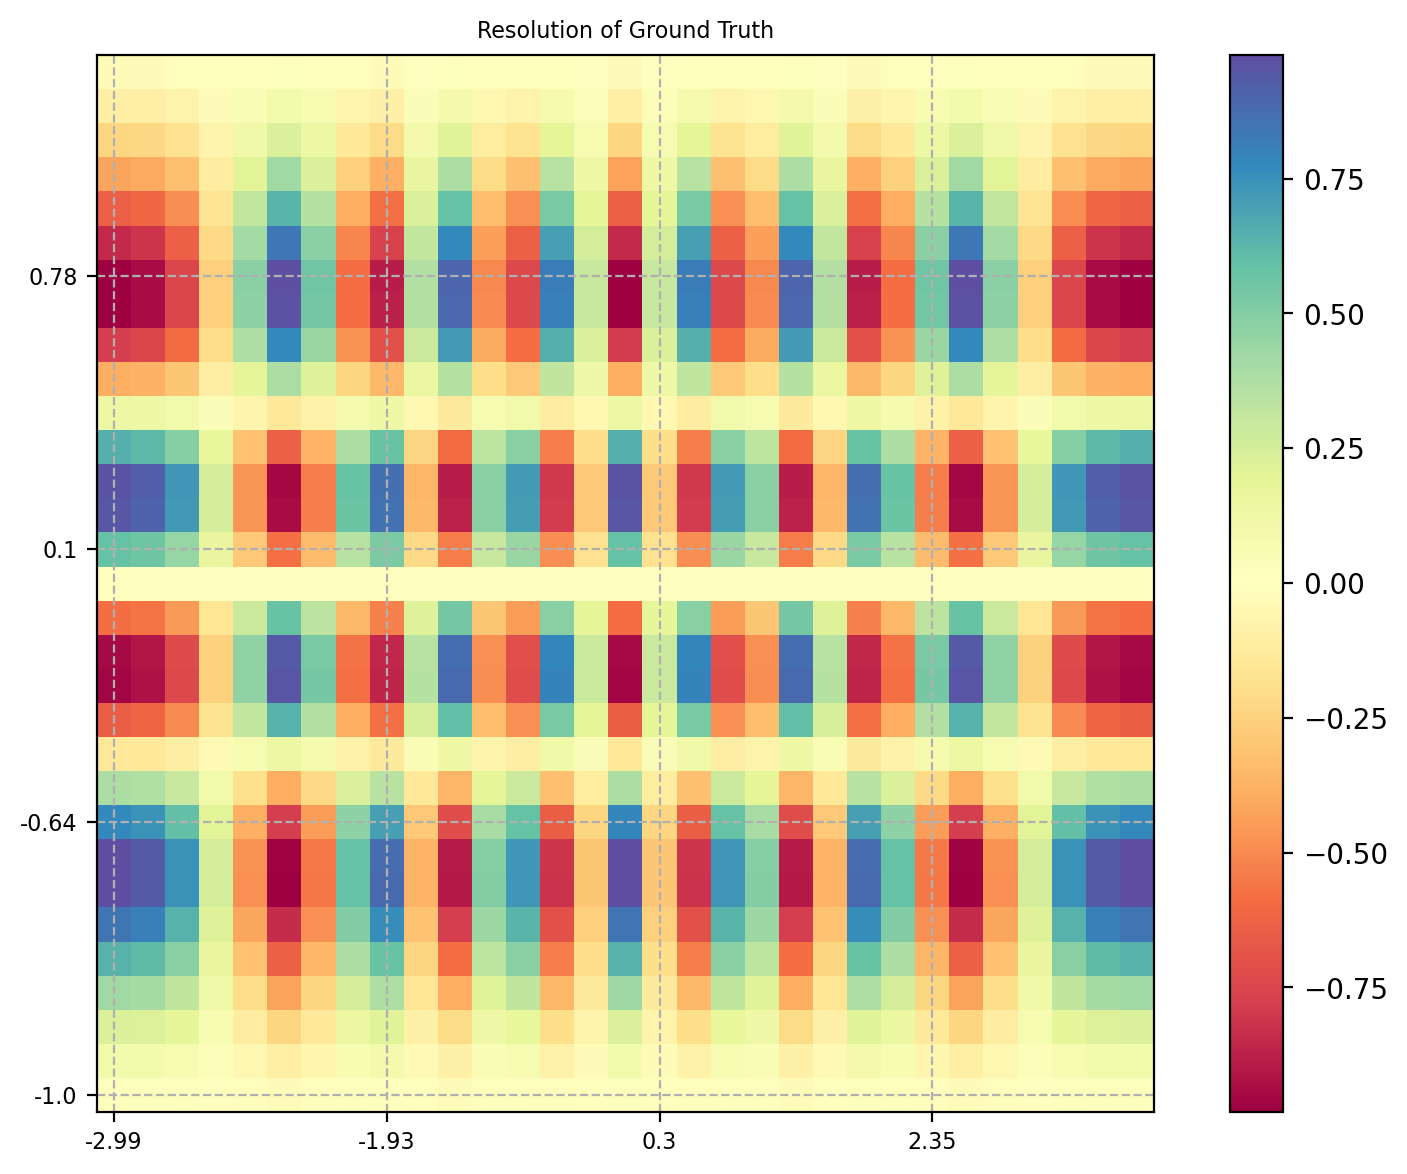

In [23]:
grid_2d = sob_2d.get_grid()
fn = "gt_resolution_poisson_eq_2d"
solver.plot2d(gt(grid_2d[:,0], grid_2d[:,1]).reshape(len(xs_plt[0]),len(xs_plt[1])), xs_plt[0], xs_plt[1], title="Resolution of Ground Truth")#, file_name=fn)

In [25]:
# Analytic Gradient Flow
start = time.time()
KsK = 2*matmul(dmn.T, K.T, metric_2d(matmul(K, dmn)))\
        +2*matmul(bndr_0.T, metric_1d_0(bndr_0))\
        +2*matmul(bndr_1.T, metric_1d_1(bndr_1))

Ksf = 2*matmul(dmn.T, K.T, metric_2d(-fXY))\
        +2*matmul(bndr_0.T, metric_1d_0(u_bndr_0))\
        +2*matmul(bndr_1.T, metric_1d_1(u_bndr_1))

w = matmul(KsK.inverse(), Ksf)
model.set_weights(w)
end = time.time()
print('time consumption: %.2fs' % (end-start))

time consumption: 0.27s


In [233]:
# Discrete Gradient Flow
optimizer = torch.optim.LBFGS(solver.model.parameters())
solver.train(30, 10, optim=optimizer)
print('time consumption: %.2fs' % solver.get_time())

epoch 200: loss = 0.0000446120030205
epoch 400: loss = 0.0000257891460632
epoch 600: loss = 0.0000146877085357
epoch 800: loss = 0.0000080077226461
epoch 1000: loss = 0.0000041684734448
time consumption: 129.13s


### Benchmarks

In [26]:
# Plot Losses
#solver.plot_losses(lower=0, upper=-1)

In [27]:
# Evaluate
_, _ = solver.eval()

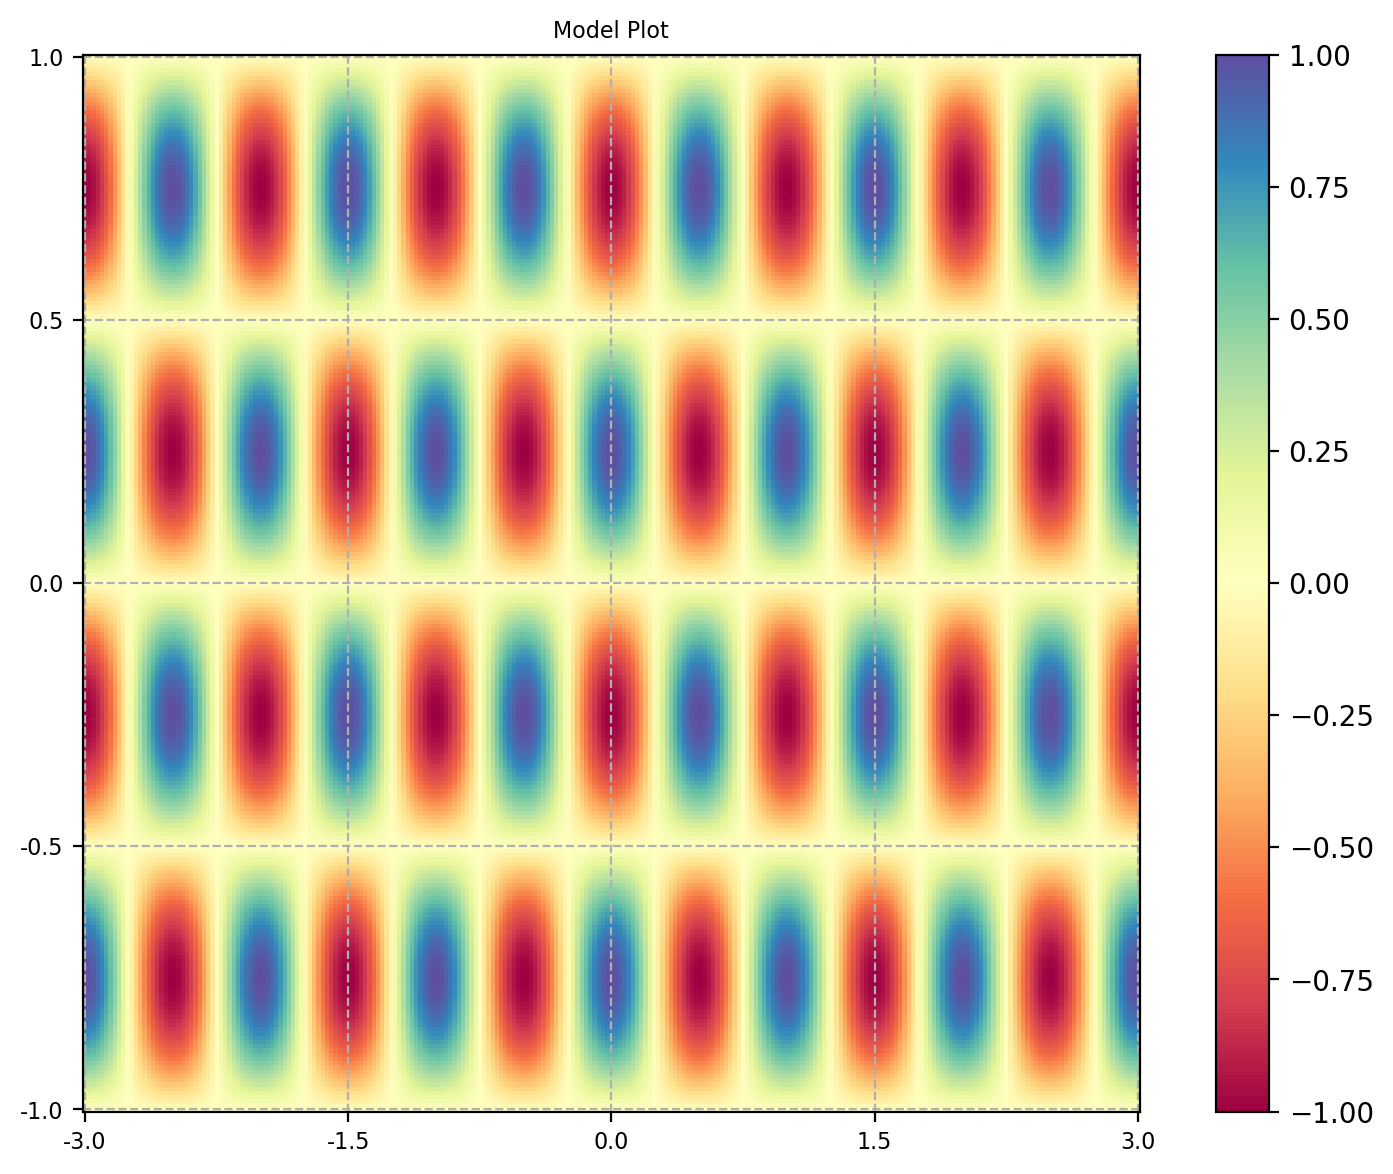

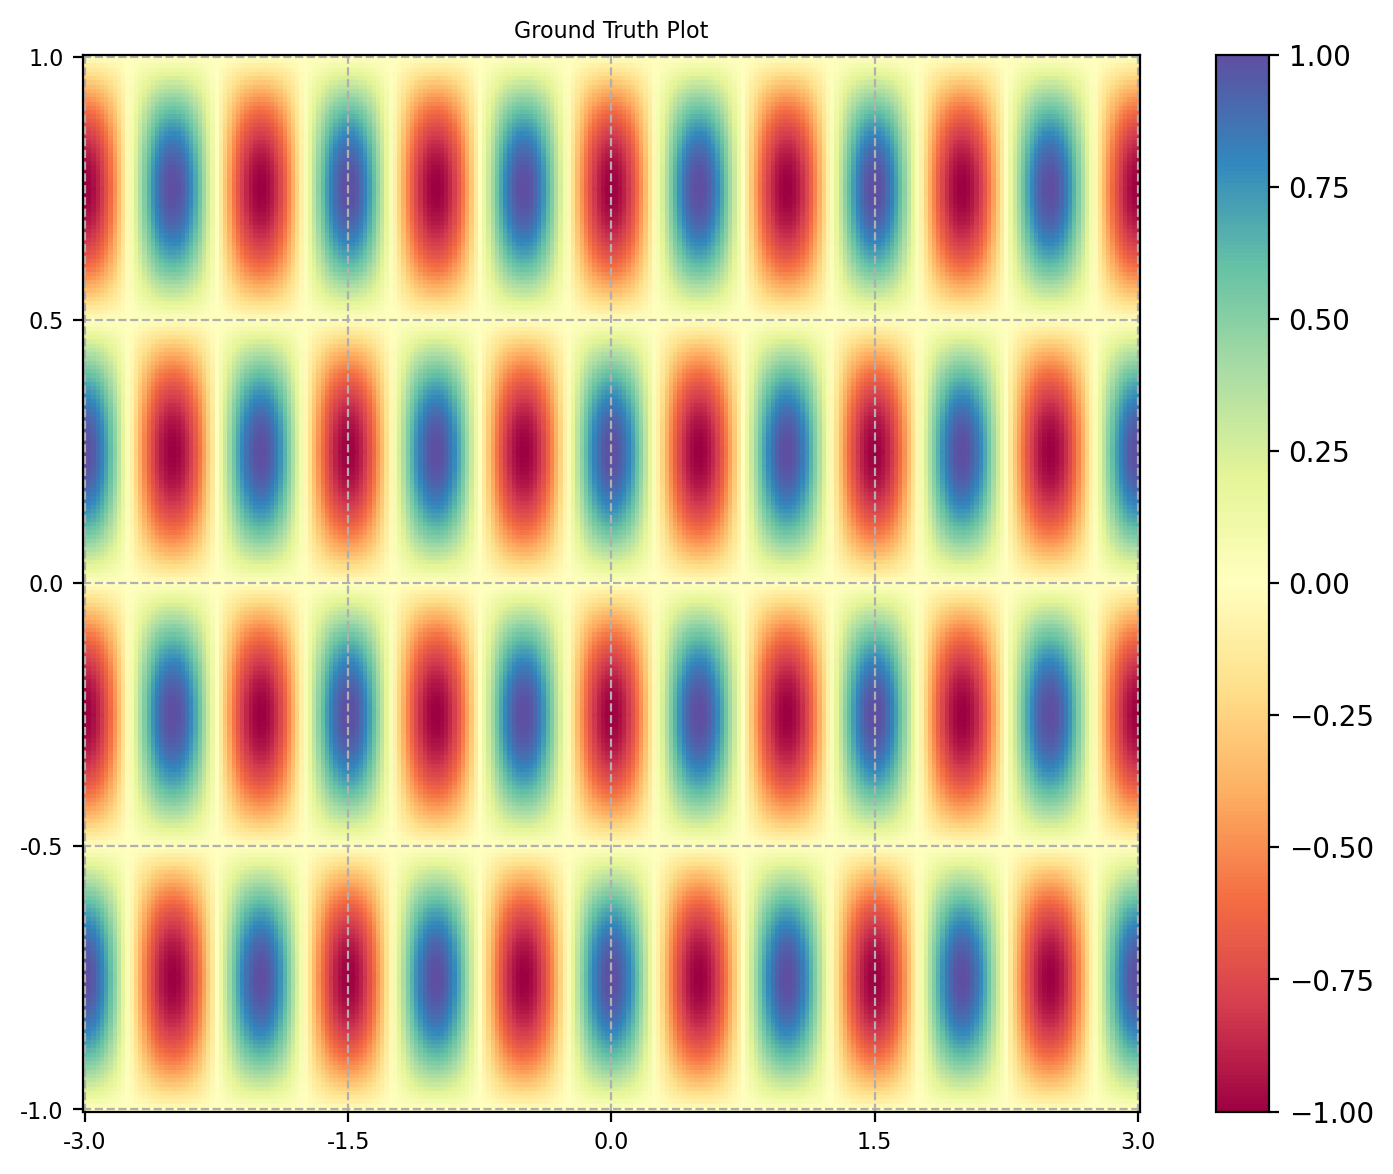

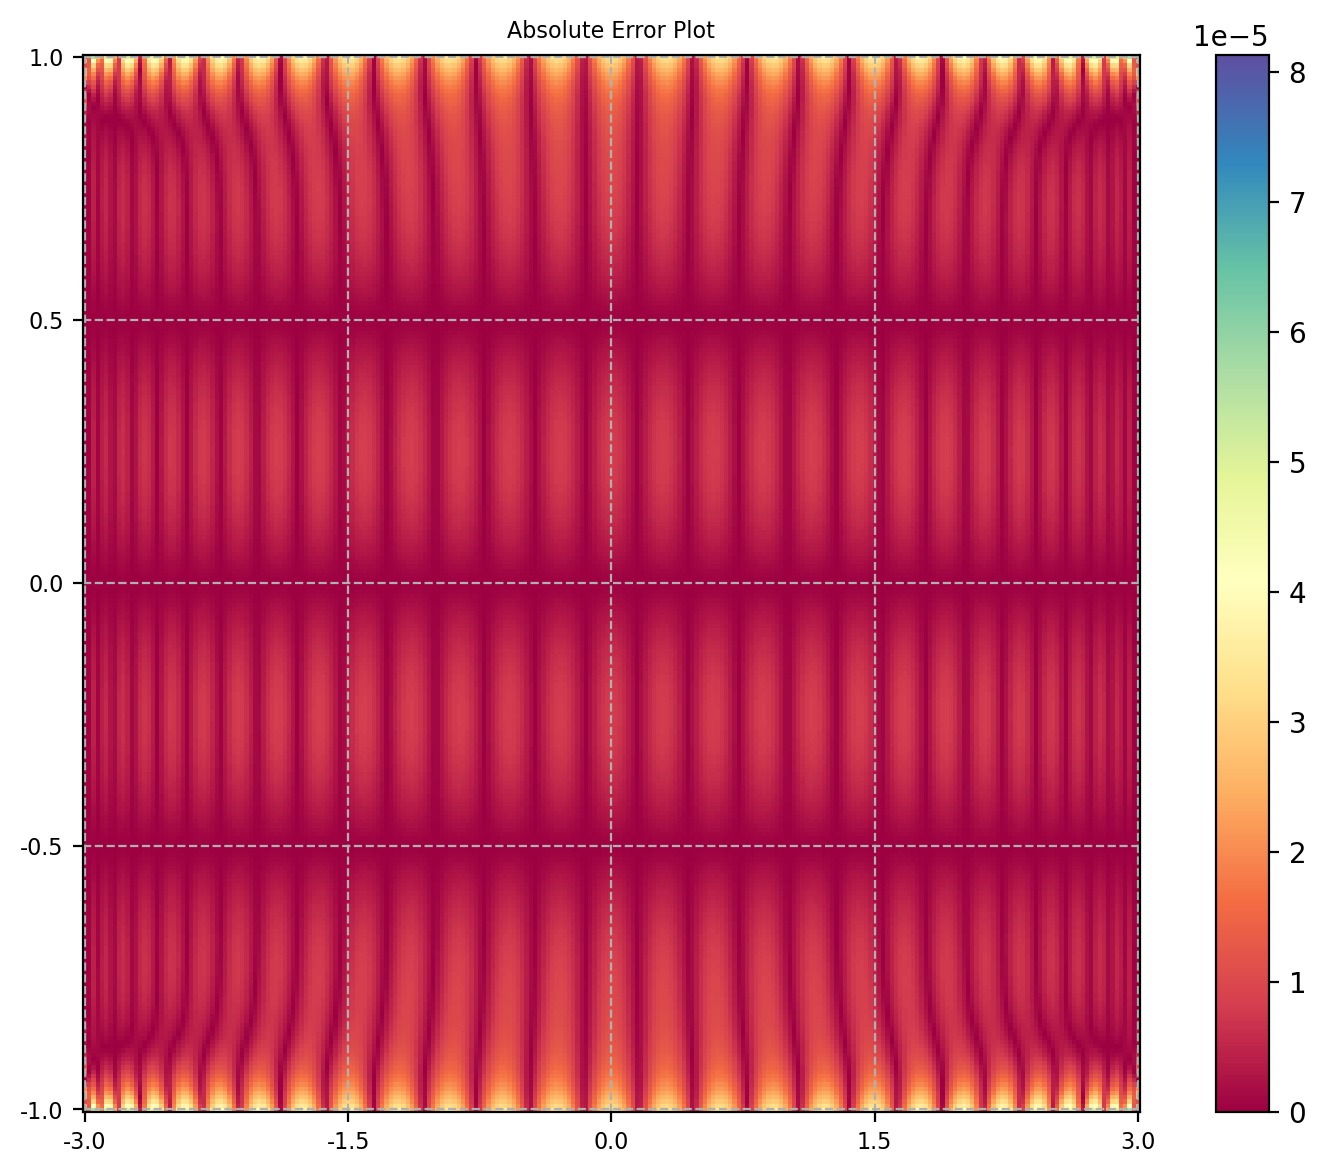

In [28]:
# Plots
suffix = None#"poisson2d"
solver.plot_model(suffix=suffix)
solver.plot_gt(suffix=suffix)
solver.plot_abs_err(suffix=suffix)

In [29]:
# Errors
print(f'L1  Error: {solver.lp_err(1)}')
print(f'L2  Error: {solver.lp_err(2)}')
print(f'Max Error: {solver.lp_err(np.inf)}')

L1  Error: 4.637629592333067e-06
L2  Error: 6.8886114785309e-06
Max Error: 8.134654350855975e-05
